In [1]:
import torch
import os
from torch.utils.data import TensorDataset,ConcatDataset,DataLoader
import matplotlib.pyplot as plt
from torch import nn
from torch.nn.functional import relu
from tqdm import tqdm
from sklearn.preprocessing import RobustScaler
import seaborn as sns

device = 'cuda'
path_to_pt_ekyn = f'../pt_ekyn'
path_to_pt_snezana_mice = f'../pt_snezana_mice'

ekyn_ids = sorted(set([recording_filename.split('_')[0] for recording_filename in os.listdir(path_to_pt_ekyn)]))
snezana_mice_ids = sorted(set([recording_filename.split('.')[0] for recording_filename in os.listdir(path_to_pt_snezana_mice)]))
print(len(ekyn_ids),ekyn_ids)
print(len(snezana_mice_ids),snezana_mice_ids)

def load_ekyn(id,condition):
    X,y = torch.load(f'{path_to_pt_ekyn}/{id}_{condition}.pt',weights_only=False)
    return X,y
def load_snezana_mice(id):
    X,y = torch.load(f'{path_to_pt_snezana_mice}/{id}.pt',weights_only=False)
    return X,y

16 ['A1-0', 'A1-1', 'A4-0', 'B1-0', 'B3-1', 'C1-0', 'C4-0', 'C4-1', 'D1-0', 'E1-0', 'E2-1', 'E4-0', 'E4-1', 'F1-0', 'F1-1', 'F5-1']
58 ['21-HET-1', '21-HET-10', '21-HET-11', '21-HET-12', '21-HET-13', '21-HET-2', '21-HET-3', '21-HET-4', '21-HET-5', '21-HET-7', '21-HET-8', '21-HET-9', '21-KO-1', '21-KO-10', '21-KO-11', '21-KO-12', '21-KO-2', '21-KO-3', '21-KO-4', '21-KO-5', '21-KO-6', '21-KO-7', '21-KO-8', '21-KO-9', '21-WK-1', '21-WK-10', '21-WK-11', '21-WK-12', '21-WK-13', '21-WK-15', '21-WK-16', '21-WK-17', '21-WK-18', '21-WK-2', '21-WK-3', '21-WK-4', '21-WK-5', '21-WK-6', '21-WK-8', '21-WK-9', '21-WT-1', '21-WT-10', '21-WT-12', '21-WT-13', '21-WT-2', '21-WT-3', '21-WT-4', '21-WT-5', '21-WT-6', '21-WT-7', '21-WT-8', '21-WT-9', '354', '378', '381', '382', '386', '429']


In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Residual Block (unchanged)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet for EEG
class EEGResNet(nn.Module):
    def __init__(self, num_classes=16):
        super(EEGResNet, self).__init__()
        self.in_channels = 16

        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, stride=2, padding=3, bias=False)  # 5000 -> 2500
        self.bn1 = nn.BatchNorm1d(16)
        self.pool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)  # 2500 -> 1250

        self.layer1 = self._make_layer(16, 2, stride=1)   # 1250
        self.layer2 = self._make_layer(32, 2, stride=2)   # 625
        self.layer3 = self._make_layer(64, 2, stride=2)   # 313
        self.layer4 = self._make_layer(128, 2, stride=2)  # 157

        self.avgpool = nn.AdaptiveAvgPool1d(1)  # 157 -> 1
        self.fc = nn.Linear(128, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [3]:
conditions = ['PF','Vehicle']
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, id, condition):
        self.X,_ = load_ekyn(id=ekyn_ids[id],condition=conditions[condition])
        self.X = self.X.unsqueeze(1)
        self.y = torch.tensor(id,dtype=torch.long)

    def __len__(self):
        return len(self.X) - 8

    def __getitem__(self, idx):
        return self.X[idx:idx+9].permute(1,0,2).flatten(1,2), self.y

In [4]:
train_dataset = ConcatDataset([EEGDataset(id=id,condition=0) for id in range(4)])
test_dataset = ConcatDataset([EEGDataset(id=id,condition=1) for id in range(4)])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGResNet(num_classes=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

100%|██████████| 540/540 [01:00<00:00,  8.99it/s]


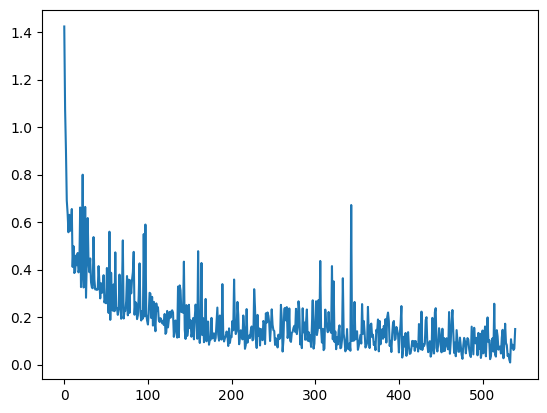

In [6]:
model.train()
lossi = []
for x, y in tqdm(train_loader):
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    outputs = model(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    lossi.append(loss.item())
plt.plot(lossi)


In [7]:
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

y = torch.vstack([torch.vstack([model(Xi.to(device)).softmax(dim=1).argmax(dim=1).detach().cpu(),yi]).T for Xi,yi in train_loader])
y_pred = y[:,0]
y_true = y[:,1]
print(classification_report(y_true=y_true,y_pred=y_pred))

y = torch.vstack([torch.vstack([model(Xi.to(device)).softmax(dim=1).argmax(dim=1).detach().cpu(),yi]).T for Xi,yi in test_loader])
y_pred = y[:,0]
y_true = y[:,1]
print(classification_report(y_true=y_true,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      8632
           1       0.98      0.93      0.96      8632
           2       1.00      1.00      1.00      8632
           3       0.99      1.00      0.99      8632

    accuracy                           0.98     34528
   macro avg       0.98      0.98      0.98     34528
weighted avg       0.98      0.98      0.98     34528

              precision    recall  f1-score   support

           0       0.24      0.40      0.30      8632
           1       0.23      0.22      0.23      8632
           2       0.19      0.16      0.17      8632
           3       0.24      0.11      0.15      8632

    accuracy                           0.23     34528
   macro avg       0.22      0.23      0.21     34528
weighted avg       0.22      0.23      0.21     34528

